## 基于语法模型

In [17]:
hello_rules = '''
say_hello = names hello tail 
names = name names | name
name = Jhon | Mike | 老梁 | 老刘 
hello = 你好 | 您来啦 | 快请进
tail = 呀 | ！
'''

In [66]:
import random
def generate(grammar_rule, target):
    if target in grammar_rule: # names 
        candidates = grammar_rule[target]  # ['name names', 'name']
        candidate = random.choice(candidates) #'name names', 'name'
        # 添加名字的去重
        if target == "name":
            grammar_rule[target].remove(candidate)
            
        return ' '.join(generate(grammar_rule, target=c.strip()) for c in candidate.split())
    else:
        return target


In [57]:

def get_generation_by_gram(grammar_str: str, target, stmt_split='=', or_split='|'):

    rules = dict() # key is the @statement, value is @expression
    for line in grammar_str.split('\n'):
        if not line: continue
        stmt, expr = line.split(stmt_split)
        #print(stmt, expr)
        rules[stmt.strip()] = expr.split(or_split)
    generated = generate(rules, target=target)
    
    return generated

In [70]:
get_generation_by_gram(hello_rules, 'say_hello')

'老刘 Mike 快请进 呀'

In [71]:
simple_grammar = """
sentence => noun_phrase verb_phrase
noun_phrase => Article Adj* noun
Adj* => Adj | Adj Adj*
verb_phrase => verb noun_phrase
Article =>  一个 | 这个
noun =>   女人 |  篮球 | 桌子 | 小猫
verb => 看着   |  坐在 |  听着 | 看见
Adj =>   蓝色的 |  好看的 | 小小的"""

In [72]:
get_generation_by_gram(simple_grammar, target='sentence', stmt_split='=>')



'这个 小小的 小猫 看着 一个 小小的 小小的 好看的 小猫'

In [73]:
simpel_programming = '''
if_stmt => if ( cond ) { stmt }
cond => var op var
op => | == | < | >= | <= 
stmt => assign | if_stmt
assign => var = var
var =>  char var | char
char => a | b |  c | d | 0 | 1 | 2 | 3
'''

In [74]:
get_generation_by_gram(simpel_programming, target='if_stmt', stmt_split="=>")

'if ( d 1 3 >= b ) { if ( d <= 3 ) { a = 2 2 d } }'

基于概率的模型  
2-gram  
$$ Pr(sentence) = Pr(w_1 \cdot w_2 \cdots w_n) = \prod \frac{count(w_i, w_{i+1})}{count(w_i)}$$


In [1]:
corpus = '../data/article_9k.txt'

In [2]:
FILE = open(corpus).read()

In [3]:
import random
def generate_by_pro(text_corpus, length=20):
    return ''.join(random.sample(text_corpus, length))

In [4]:
len(FILE)
        

33425826

In [5]:
generate_by_pro(text_corpus=FILE)



'对华3４择经年题举一2出量２由外年式１期'

In [6]:
import jieba

In [7]:
max_length = 1000000 

sub_file = FILE[:max_length]
sub_file = FILE

In [8]:
# 分词
def cut(string):
    return list(jieba.cut(string))

In [9]:
TOKENS = cut(sub_file)


Building prefix dict from the default dictionary ...
Loading model from cache /var/folders/0j/fhgjckfx0jzg_46p26d7fz8m0000gn/T/jieba.cache
Loading model cost 0.543 seconds.
Prefix dict has been built succesfully.


In [10]:
len(TOKENS)

17618254

In [11]:
# 计数器
from collections import Counter

In [12]:
%matplotlib inline



In [13]:
words_count = Counter(TOKENS)

In [14]:
words_count.most_common(10)



[('的', 703716),
 ('n', 382020),
 ('在', 263597),
 ('月', 189330),
 ('日', 166300),
 ('新华社', 142462),
 ('和', 134061),
 ('年', 123106),
 ('了', 121938),
 ('是', 100909)]

In [15]:
words_with_fre = [f for w, f in words_count.most_common()]

In [16]:
import matplotlib.pyplot as plt



In [17]:
words_with_fre[:10]



[703716,
 382020,
 263597,
 189330,
 166300,
 142462,
 134061,
 123106,
 121938,
 100909]

In [18]:
import numpy as np

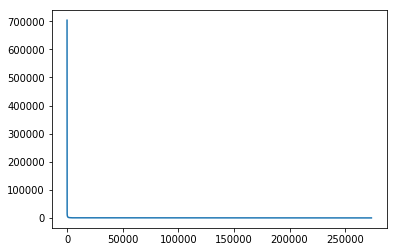

In [19]:
plt.plot(words_with_fre)

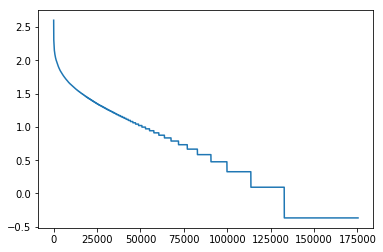

In [20]:
plt.plot(np.log(np.log(words_with_fre)))



In [21]:
_2_gram_words = [
    TOKENS[i] + TOKENS[i+1] for i in range(len(TOKENS)-1)
]

In [22]:
_2_gram_words[:10]

['此外自', '自本周', '本周6', '6月', '月12', '12日起', '日起除', '除小米', '小米手机', '手机6']

In [23]:
_2_gram_word_counts = Counter(_2_gram_words)



In [24]:
_2_gram_word_counts.most_common(10)

[('\n新华社', 69033),
 ('2017年', 61480),
 ('外代二线', 61301),
 ('n新华社', 59794),
 ('日n', 52216),
 ('新华社照片', 50401),
 ('5月', 37977),
 ('4月', 34571),
 ('新华社记者', 30864),
 ('２０', 27166)]

In [25]:
def get_1_gram_count(word):
    if word in words_count: 
        return words_count[word]
    else:
        return words_count.most_common()[-1][-1]

In [26]:
def get_2_gram_count(word):
    if word in _2_gram_word_counts: 
        return _2_gram_word_counts[word]
    else:
        return _2_gram_word_counts.most_common()[-1][-1]

In [27]:
def get_gram_count(word, wc):
    if word in wc: 
        return wc[word]
    else:
        return wc.most_common()[-1][-1]


In [28]:
def two_gram_model(sentence):
    # 2-gram langauge model
    tokens = cut(sentence)
    
    probability = 1
    
    for i in range(len(tokens)-1):
        word = tokens[i]
        next_word = tokens[i+1]
        
        _two_gram_c = get_gram_count(word+next_word, _2_gram_word_counts)
        _one_gram_c = get_gram_count(next_word, words_count)
        pro =  _two_gram_c / _one_gram_c
        
        probability *= pro
    
    return probability  



In [29]:
two_gram_model("苹果手机信号很差")

0.0026041666666666665

In [63]:
two_gram_model("华为手机比小米手机好")

6.481019603885326e-17

In [64]:
two_gram_model("卡回单卡是的撒肯定会是肯定会")



3.370005446528566e-24

3-gram  
$$ Pr(sentence) = Pr(w_1 \cdot w_2 \cdots w_n) = \prod \frac{count(w_i, w_{i+1},w_{i+2})}{count(w_i,w_{i+1})}$$




In [31]:
_3_gram_words = [
    TOKENS[i] + TOKENS[i+1]+ TOKENS[i+2] for i in range(len(TOKENS)-2)
]


In [32]:
_3_gram_word_counts = Counter(_3_gram_words)



In [33]:
def three_gram_model(sentence):
    # 3-gram langauge model
    tokens = cut(sentence)
    
    probability = 1
    
    for i in range(len(tokens)-2):
        word = tokens[i]
        next_word = tokens[i+1]
        third_word = tokens[i+2]
        
        _three_gram_c = get_gram_count(word+next_word+third_word, _3_gram_word_counts)
        _two_gram_c = get_gram_count(next_word+next_word, _2_gram_word_counts)
        pro =  _three_gram_c / _two_gram_c
        
        probability *= pro
    
    return probability  

In [34]:
three_gram_model("小米手机真的很牛")

0.3333333333333333